In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import corner
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2  # Import L2 regularization
from sklearn.preprocessing import StandardScaler
import joblib

2024-04-15 15:35:56.562760: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 15:35:59.869238: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 15:35:59.886523: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 15:36:03.096343: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load and split the dataset

In [2]:
data = pd.read_csv('Alignment-2-Learning.csv')

In [3]:
data.head()

,mH1,mH2,mH3,mA1,mA2,mC1,mC2,TanBeta1,TanBeta2,TanAlpha4,TanGamma1,TanGamma2,TanAlpha1,TanAlpha2,Output
0,80.399476,125,364.984809,233.196426,225.809015,261.490244,344.746092,2.975914,0.990482,1.000000e+20,23.762923,29.196897,2.975914,-1.009610,1
1,97.274483,125,374.515804,222.785111,492.135392,204.034939,248.065984,3.336800,0.850561,1.000000e+20,11.111333,24.101006,3.336800,-1.175695,1
2,87.860330,125,311.972522,221.080517,307.763485,531.084299,426.052734,1.224131,1.099337,1.000000e+20,19.140903,17.731604,1.224131,-0.909639,1
3,81.195458,125,352.757214,333.067994,237.625219,463.106025,301.331332,1.496171,0.886333,1.000000e+20,28.488928,10.436856,1.496171,-1.128244,1
4,90.805059,125,494.838720,511.165367,218.875305,268.286804,218.669384,1.443027,1.059952,1.000000e+20,26.674671,6.333469,1.443027,-0.943439,1


In [4]:
#check for any empty cell in the database
data.isna().sum()

mH1          0
mH2          0
mH3          0
mA1          0
mA2          0
mC1          0
mC2          0
TanBeta1     0
TanBeta2     0
TanAlpha4    0
TanGamma1    0
TanGamma2    0
TanAlpha1    0
TanAlpha2    0
Output       0
dtype: int64

In [12]:
#shuffle the dataframe

data_sh = data.sample(frac = 1.0, random_state = 53)

#reset the index

data_sh = data_sh.reset_index(drop=True)

In [13]:
#put feature variable to X and target variable to Y

X = data_sh.drop('Output', axis = 1)
Y = data_sh['Output']

In [14]:
# data preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

column_names = ['mH1','mH2','mH3','mA1','mA2','mC1','mC2','TanBeta1','TanBeta2','TanAlpha4','TanGamma1','TanGamma2','TanAlpha1','TanAlpha2']

X = pd.DataFrame(X_scaled, columns=column_names)

In [15]:
#scaler_filename = "Alignment2-scaler.save"
#joblib.dump(scaler, scaler_filename)

In [16]:
#Split into train data and test data

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.915, random_state = 53)

#Split the training data further into labeled and unlabeled dataset

X_labeled, X_unlabeled, Y_labeled, Y_unlabeled = train_test_split(X_train, Y_train, test_size = 0.9997, random_state = 53)

In [17]:
print(f"Total Number of datapoints: {len(X)}")
print(f"Number of labeled datapoints: {len(X_labeled)}")
print(f"Number of unlabeled datapoints: {len(X_unlabeled)}")
print(f"Number of test datapoints: {len(X_test)}")

Total Number of datapoints: 115777
Number of labeled datapoints: 2
Number of unlabeled datapoints: 9839
Number of test datapoints: 105936


In [18]:
frac_unlabeled = Y_unlabeled.sum()/len(Y_unlabeled)
frac_labeled = Y_labeled.sum()/len(Y_labeled)
frac_test = Y_test.sum()/len(Y_test)

In [19]:
print(f"Fraction of allowed points in labeled dataset: {frac_labeled}")
print(f"Fraction of allowed points in unlabeled dataset: {frac_unlabeled}")
print(f"Fraction of allowed points in test dataset: {frac_test}")

Fraction of allowed points in labeled dataset: 0.5
Fraction of allowed points in unlabeled dataset: 0.44130501067181627
Fraction of allowed points in test dataset: 0.4383212505663797


## Neural Network Model

In [20]:
# Set random seeds for reproducibility
seed_value = 53
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

import random
random.seed(seed_value)

In [21]:
#define your model
model = keras.Sequential()

# Add input layer with 14 input parameters
model.add(layers.Input(shape=(X.shape[1],)))

model.add(layers.Dense(128, kernel_regularizer=l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.6))

model.add(layers.Dense(32, kernel_regularizer=l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.6))

model.add(layers.Dense(32, kernel_regularizer=l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.6))

model.add(layers.Dense(64, kernel_regularizer=l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.6))



model.add(layers.Dense(1, activation = 'sigmoid'))

custom_learning_rate = 0.001  

# Compile the model with a custom learning rate
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=custom_learning_rate)
model.compile(loss='binary_crossentropy', optimizer=custom_optimizer)

# Display the model summary to see the architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1920      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                       

## Active Learning Loop

In [22]:
#active learning loop
num_iterations = 41

num_it_array = np.arange(1,num_iterations+2,1)
accuracy_array = np.zeros(num_iterations+1)
precision_array = np.zeros(num_iterations+1)
recall_array = np.zeros(num_iterations+1)
f1_array = np.zeros(num_iterations+1)

for iteration in range(num_iterations):
    #Train the model
    model.fit(X_labeled,Y_labeled, epochs=150, batch_size=32, verbose=0)
    
    #Get model predictions on the test data
    Y_pred_test = model.predict(X_test, verbose=0).ravel()   
    
    #Convert the predictions into binary
    Y_pred_binary = (Y_pred_test > 0.9).astype(int)
    
    #Calculate accuracy,precision,recall and F1 Score on the test set
    accuracy = accuracy_score(Y_test, Y_pred_binary)
    accuracy_array[iteration] = accuracy
    precision = precision_score(Y_test, Y_pred_binary)
    precision_array[iteration] = precision
    recall = recall_score(Y_test, Y_pred_binary)
    recall_array[iteration] = recall
    f1 = f1_score(Y_test, Y_pred_binary)
    f1_array[iteration] = f1
    frac_labeled = Y_labeled.sum()/len(Y_labeled)
    print(f"Iteration : {iteration + 1}: Test Accuracy = {accuracy:.6f}")
    print(f"Iteration : {iteration + 1}: Test Precision = {precision:.6f}")
    print(f"Iteration : {iteration + 1}: Test Recall = {recall:.6f}")
    print(f"Iteration : {iteration + 1}: Test F1 = {f1:.6f}")
    print(f"Iteration : {iteration + 1}: Fraction of allowed points in labeled dataset = {frac_labeled}")
    print(" ") #Print a blank line
    
    #Get model predictions on the unlabeled data
    Y_pred_unlabel = model.predict(X_unlabeled, verbose=0).ravel()
    
    #Calculate entropy
    entropy = -Y_pred_unlabel*np.log2(Y_pred_unlabel+1e-30) - (1-Y_pred_unlabel)*np.log2(1-Y_pred_unlabel+1e-30)
    
    #Select the most uncertain samples
    num_samples_to_label = 2
    selected_indices = np.argsort(entropy)[-num_samples_to_label:]
    
    #move the selected samples from unlabeled to labeled data
    X_labeled = pd.concat([X_labeled, X_unlabeled.iloc[selected_indices]])
    Y_labeled = pd.concat([Y_labeled, pd.Series(Y_unlabeled.iloc[selected_indices])])
    
    #Remove the newly labeled samples from the unlabeled data
    X_unlabeled = X_unlabeled.drop(X_unlabeled.index[selected_indices])
    Y_unlabeled = Y_unlabeled.drop(Y_unlabeled.index[selected_indices])
    
#Train the final model on all labeled data 
model.fit(X_labeled,Y_labeled, epochs=150, batch_size=32, verbose=0)

#Evaluate the final model on the test data
Y_pred_test = model.predict(X_test, verbose=0).ravel()   
    
#Convert the predictions into binary
Y_pred_binary = (Y_pred_test > 0.9).astype(int)

#Calculate various metric scores
final_accuracy = accuracy_score(Y_test, Y_pred_binary)
accuracy_array[-1] = final_accuracy
final_precision = precision_score(Y_test, Y_pred_binary)
precision_array[-1] = final_precision
final_recall = recall_score(Y_test, Y_pred_binary)
recall_array[-1] = final_recall
final_f1 = f1_score(Y_test, Y_pred_binary)
f1_array[-1] = final_f1
frac_labeled = Y_labeled.sum()/len(Y_labeled)

print(f"Final Model Test Accuracy: {final_accuracy:.6f}")
print(f"Final Model Test Precision: {final_precision:.6f}")
print(f"Final Model Test Recall: {final_recall:.6f}")
print(f"Final Model Test F1: {final_f1:.6f}")
print(f"Fraction of allowed points in labeled dataset: {frac_labeled}")

/home/akshat/work_env/work_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration : 1: Test Accuracy = 0.561679
Iteration : 1: Test Precision = 0.000000
Iteration : 1: Test Recall = 0.000000
Iteration : 1: Test F1 = 0.000000
Iteration : 1: Fraction of allowed points in labeled dataset = 0.5
 


/home/akshat/work_env/work_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration : 2: Test Accuracy = 0.561679
Iteration : 2: Test Precision = 0.000000
Iteration : 2: Test Recall = 0.000000
Iteration : 2: Test F1 = 0.000000
Iteration : 2: Fraction of allowed points in labeled dataset = 0.75
 


/home/akshat/work_env/work_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration : 3: Test Accuracy = 0.561679
Iteration : 3: Test Precision = 0.000000
Iteration : 3: Test Recall = 0.000000
Iteration : 3: Test F1 = 0.000000
Iteration : 3: Fraction of allowed points in labeled dataset = 0.5
 


/home/akshat/work_env/work_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration : 4: Test Accuracy = 0.561679
Iteration : 4: Test Precision = 0.000000
Iteration : 4: Test Recall = 0.000000
Iteration : 4: Test F1 = 0.000000
Iteration : 4: Fraction of allowed points in labeled dataset = 0.375
 
Iteration : 5: Test Accuracy = 0.562764
Iteration : 5: Test Precision = 1.000000
Iteration : 5: Test Recall = 0.002477
Iteration : 5: Test F1 = 0.004941
Iteration : 5: Fraction of allowed points in labeled dataset = 0.4
 
Iteration : 6: Test Accuracy = 0.655990
Iteration : 6: Test Precision = 0.998901
Iteration : 6: Test Recall = 0.215403
Iteration : 6: Test F1 = 0.354386
Iteration : 6: Fraction of allowed points in labeled dataset = 0.3333333333333333
 
Iteration : 7: Test Accuracy = 0.772806
Iteration : 7: Test Precision = 0.998085
Iteration : 7: Test Recall = 0.482599
Iteration : 7: Test F1 = 0.650611
Iteration : 7: Fraction of allowed points in labeled dataset = 0.35714285714285715
 
Iteration : 8: Test Accuracy = 0.856479
Iteration : 8: Test Precision = 0.99894

Iteration : 39: Test Accuracy = 0.999622
Iteration : 39: Test Precision = 0.999569
Iteration : 39: Test Recall = 0.999569
Iteration : 39: Test F1 = 0.999569
Iteration : 39: Fraction of allowed points in labeled dataset = 0.4230769230769231
 
Iteration : 40: Test Accuracy = 0.999764
Iteration : 40: Test Precision = 0.999548
Iteration : 40: Test Recall = 0.999914
Iteration : 40: Test F1 = 0.999731
Iteration : 40: Fraction of allowed points in labeled dataset = 0.4375
 
Iteration : 41: Test Accuracy = 0.999792
Iteration : 41: Test Precision = 0.999526
Iteration : 41: Test Recall = 1.000000
Iteration : 41: Test F1 = 0.999763
Iteration : 41: Fraction of allowed points in labeled dataset = 0.45121951219512196
 
Final Model Test Accuracy: 0.999764
Final Model Test Precision: 0.999462
Final Model Test Recall: 1.000000
Final Model Test F1: 0.999731
Fraction of allowed points in labeled dataset: 0.4523809523809524


In [223]:
#model.save('Alignment-2.keras')

Text(0, 0.5, 'F1-score')

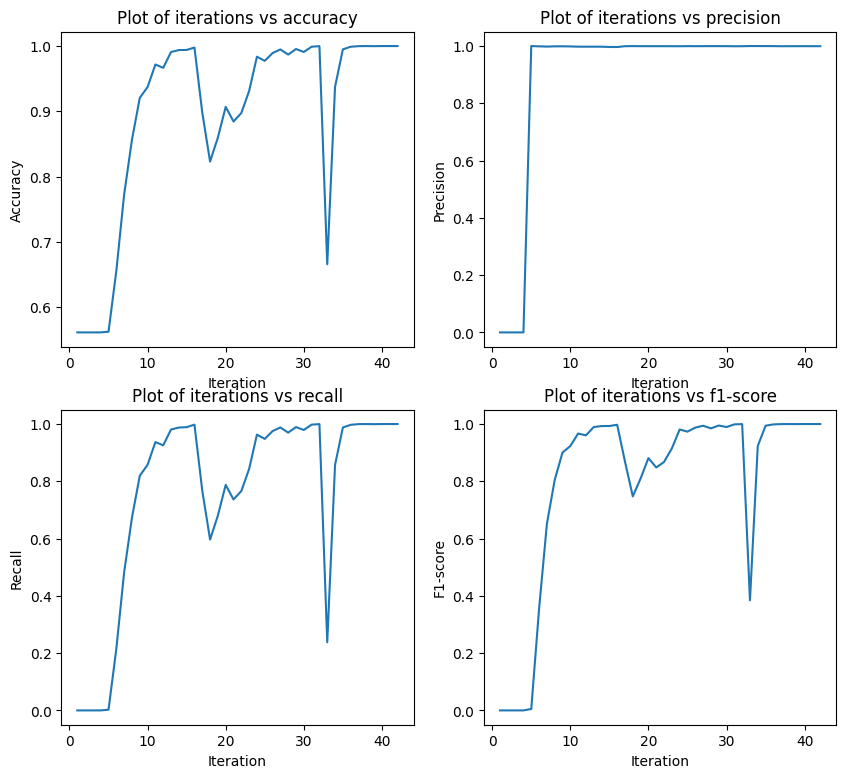

In [23]:
# Plot iteration vs accuracy

plt.figure(figsize=(10, 9))

plt.subplot(2,2,1)
plt.plot(num_it_array, accuracy_array)
plt.title("Plot of iterations vs accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

# Plot iteration vs precision

plt.subplot(2,2,2)
plt.plot(num_it_array, precision_array)
plt.title("Plot of iterations vs precision")
plt.xlabel("Iteration")
plt.ylabel("Precision")

# Plot iteration vs recall

plt.subplot(2,2,3)
plt.plot(num_it_array, recall_array)
plt.title("Plot of iterations vs recall")
plt.xlabel("Iteration")
plt.ylabel("Recall")

# Plot iteration vs f1-score

plt.subplot(2,2,4)
plt.plot(num_it_array, f1_array)
plt.title("Plot of iterations vs f1-score")
plt.xlabel("Iteration")
plt.ylabel("F1-score")

#plt.tight_layout()
#plt.savefig("Neural.pdf", bbox_inches = 'tight', dpi = 200, format="pdf")